In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, HeatMap

In [2]:
#process the data
df = pd.read_csv("data/clean_data.csv", parse_dates=['OCC_DATE'])

In [3]:
df.head()

,OBJECTID,OCC_DATE,OCC_HOUR,LOCATION_TYPE,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,MCI_CATEGORY,dayofweek,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,year,month,isholiday,lat_hour_cos,lat_hour_sin,long_hour_cos,long_hour_sin
0,2,2014-01-01 05:00:00+00:00,3,Commercial Dwelling Unit,South Riverdale,-79.350229,43.646293,Break and Enter,2,0.974928,-0.222521,0.707107,0.707107,2014,1,True,30.862590,30.862590,-56.109085,-56.109085
1,3,2014-01-01 05:00:00+00:00,4,Apartment,North St.James Town,-79.376497,43.666423,Assault,2,0.974928,-0.222521,0.866025,0.500000,2014,1,True,21.833211,37.816231,-39.688249,-68.742063
2,4,2014-01-01 05:00:00+00:00,4,"Streets, Roads, Highways",NSA,-85.488744,0.000000,Theft Over,2,0.974928,-0.222521,0.866025,0.500000,2014,1,True,0.000000,0.000000,-42.744372,-74.035424
3,5,2014-01-01 05:00:00+00:00,4,"Streets, Roads, Highways",Blake-Jones,-79.344839,43.678946,Assault,2,0.974928,-0.222521,0.866025,0.500000,2014,1,True,21.839473,37.827077,-39.672420,-68.714646
4,6,2014-01-01 05:00:00+00:00,2,Bar / Restaurant,Wellington Place,-79.391841,43.646639,Assault,2,0.974928,-0.222521,0.500000,0.866025,2014,1,True,37.799098,21.823320,-68.755351,-39.695921


***

In [4]:
# Group by year, month, and crime, and count the number of crimes create a new dataframe that allows us to plot
crime_YM_counts = df.groupby(['year', 'month', 'MCI_CATEGORY']).size().reset_index(name='CrimeCount')

# Combine 'Year' and 'Month' columns to create a new 'Date' column
crime_YM_counts['Date'] = pd.to_datetime(crime_YM_counts[['year', 'month']].assign(day=1))


In [5]:
crime_YM_counts.head()

,year,month,MCI_CATEGORY,CrimeCount,Date
0,2014,1,Assault,1363,2014-01-01
1,2014,1,Auto Theft,240,2014-01-01
2,2014,1,Break and Enter,586,2014-01-01
3,2014,1,Robbery,291,2014-01-01
4,2014,1,Theft Over,103,2014-01-01


# Crime Over Time (2014~2022)

In [6]:
fig = px.line(crime_YM_counts, x='Date', y='CrimeCount',color='MCI_CATEGORY', title='Time Series Plot', width=800, height=400)
fig.update_layout(
    title='Incidents of Crime over time (2014 ~ 2022)',
    xaxis_title='Year',
    yaxis_title='Crime Count',
    legend_title='Crime Category',
    template='plotly',
)
fig.show()


# Type of Crime by time of day

In [7]:
# Group by year, month, and crime, and count the number of crimes create a new dataframe that allows us to plot
crime_hr_counts = df.groupby(['year','OCC_HOUR', 'MCI_CATEGORY']).size().reset_index(name='CrimeCount')
crime_hr_counts.head()

,year,OCC_HOUR,MCI_CATEGORY,CrimeCount
0,2014,0,Assault,1194
1,2014,0,Auto Theft,212
2,2014,0,Break and Enter,433
3,2014,0,Robbery,210
4,2014,0,Theft Over,121


In [8]:
def update_plot(selected_year):
    #clear_output(wait=True)  # Clear previous output
    filtered_data = crime_hr_counts[crime_hr_counts['year'] == selected_year]
    fig = px.line(filtered_data,
                 x='OCC_HOUR',
                 y='CrimeCount',
                 color='MCI_CATEGORY',
                 labels={'Month': 'Month', 'CrimeCount': 'Number of Crimes'},
                 title=f'Crime Count for Year {selected_year} by Hour')

    fig.update_layout(
    showlegend=True,
    xaxis_title='Occurance Hour',
    yaxis_title='Number of Crimes',
    legend_title='Crime Category',
    template='plotly',
    )
    fig.show()

In [9]:
# Get the unique years in the dataset
years = crime_hr_counts['year'].unique()

# Create a dropdown widget for selecting the year
dropdown = widgets.Dropdown(options=years, description='year')

# Define an event handler for the dropdown value change
def dropdown_event_handler(change):
    update_plot(change.new)

# Attach the event handler to the dropdown's value change event
dropdown.observe(dropdown_event_handler, names='value')

# Display the dropdown widget
display(dropdown)

# Initialize the plot with the first year in the dataset
initial_year = years[0] #start 2014
update_plot(initial_year)

Dropdown(description='year', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

***

# Heat Map

In [10]:
# create a dataframe that sum up by neighbourhood and crime
type_crime_df = df.groupby(['NEIGHBOURHOOD_158', 'MCI_CATEGORY']).size().reset_index(name='CrimeCount')

In [11]:
# create a wide format to plot
wide_format_df = type_crime_df.pivot(index='NEIGHBOURHOOD_158', columns='MCI_CATEGORY', values='CrimeCount')

# sum row-wise to obtain Total_Crime count in Neighbourhood
wide_format_df['Total_Crime'] = wide_format_df[['Assault','Auto Theft','Break and Enter','Robbery','Theft Over']].sum(axis=1)
wide_format_df

MCI_CATEGORY,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total_Crime
NEIGHBOURHOOD_158,,,,,,
Agincourt North,673,343,381,226,40,1663
Agincourt South-Malvern West,1124,404,657,236,103,2524
Alderwood,322,227,245,64,57,915
Annex,2403,275,1387,387,272,4724
Avondale,424,130,101,58,40,753
...,...,...,...,...,...,...
Yonge-Doris,693,177,130,150,73,1223
Yonge-Eglinton,667,123,267,106,43,1206
Yonge-St.Clair,280,78,222,31,30,641


In [12]:
# Coordinates Criminal Neighbourhoods
map_data = df[['NEIGHBOURHOOD_158', 'LAT_WGS84', 'LONG_WGS84']].drop_duplicates('NEIGHBOURHOOD_158').set_index('NEIGHBOURHOOD_158').join(wide_format_df, how='inner')

In [13]:
# Create the temporary dataframes
map_data_assault = map_data[['LAT_WGS84','LONG_WGS84','Assault']]
map_data_auto = map_data[['LAT_WGS84','LONG_WGS84','Auto Theft']]
map_data_BnE = map_data[['LAT_WGS84','LONG_WGS84','Break and Enter']]
map_data_robbery = map_data[['LAT_WGS84','LONG_WGS84','Robbery']]
map_data_theftover = map_data[['LAT_WGS84','LONG_WGS84','Theft Over']]
map_data_total = map_data[['LAT_WGS84','LONG_WGS84','Total_Crime']]

In [14]:
def popup_html(x):
    """Takes each row and organize output"""
    neighborhood = x[0]
    Assault = x[1]['Assault']
    Auto_Theft = x[1]['Auto Theft']
    Break_and_Enter = x[1]['Break and Enter']
    Robbery = x[1]['Robbery']
    Theft_Over = x[1]['Theft Over']
    Total_Crime = x[1]['Total_Crime']

    Assault_perc = round((Assault/Total_Crime),4)*100
    Auto_Theft_perc = round((Auto_Theft/Total_Crime),4) *100
    Break_and_Enter_perc = round( (Break_and_Enter/Total_Crime),4) *100
    Robbery_perc = round( (Robbery/Total_Crime),4) *100
    Theft_Over_perc = round( (Theft_Over/Total_Crime) ,4) *100

    html = f"""<!DOCTYPE html>
    <html>
    <table style="height: 120px; width: 360px;">
    <tbody>
        <tr>
            <td>Neighborhood:</td>
            <td>{neighborhood}</td>
        </tr>
        <tr>
            <td>Total Crime Count:</td>
            <td>{Total_Crime}</td>
        </tr>
        <tr>
            <td>Assault:</td>
            <td>{"{:.2f}".format(Assault_perc)}%</td>
        </tr>
        <tr>
            <td>Auto Theft:</td>
            <td>{"{:.2f}".format(Auto_Theft_perc)}%</td>
        </tr>
        <tr>
            <td>Break and Enter:</td>
            <td>{"{:.2f}".format(Break_and_Enter_perc)}%</td>
        </tr>
        <tr>
            <td>Robbery:</td>
            <td>{"{:.2f}".format(Robbery_perc)}%</td>
        </tr>
        <tr>
            <td>Theft Over $5000:</td>
            <td>{"{:.2f}".format(Theft_Over_perc)}%</td>
        </tr>
    </tbody>
    </table>
    </html>
    """
    return html

In [15]:
# Create the Map object
map = folium.Map(location=[43.651070, -79.347015], zoom_start=11.25)
folium.TileLayer('cartodbpositron').add_to(map)

# Set up Clusters object
cluster = MarkerCluster(name="Neighborhoods").add_to(map)

# Add each cluster object
for x in map_data.iterrows():
    html = popup_html(x)
    popup = folium.Popup(folium.Html(html, script=True), max_width=200)
    folium.Marker([x[1].LAT_WGS84, x[1].LONG_WGS84], popup=popup).add_to(cluster)

# Create FeatureGroup objects for heatmaps
heat_map_Total = folium.FeatureGroup(name='Total Crime Heatmap', show=False)
heat_map_Assault = folium.FeatureGroup(name='Assault Heatmap', show=False)
heat_map_Auto = folium.FeatureGroup(name='Auto Theft Heatmap', show=False)
heat_map_BnE = folium.FeatureGroup(name='Break and Enter Heatmap', show=False)
heat_map_Robbery = folium.FeatureGroup(name='Robbery Heatmap', show=False)
heat_map_Theftover = folium.FeatureGroup(name='Theftover Heatmap', show=False)


# Create heat map elements
heat1 = HeatMap(map_data_total.values,
                name="Total Crime Heatmap",
                min_opacity=0.2,
                radius=30, blur=20,
                max_zoom=11
                )
heat2 = HeatMap(map_data_assault.values,
                name="Assault Heatmap",
                min_opacity=0.2,
                radius=30, blur=20,
                max_zoom=11
                )

heat3 = HeatMap(map_data_auto.values,
                name="Auto Theft Heatmap",
                min_opacity=0.2,
                radius=30, blur=20,
                max_zoom=11
                )

heat4 = HeatMap(map_data_BnE.values,
                name="Break and Enter Heatmap",
                min_opacity=0.2,
                radius=30, blur=20,
                max_zoom=11
                )

heat5 = HeatMap(map_data_robbery.values,
                name="Robbery Heatmap",
                min_opacity=0.2,
                radius=30, blur=20,
                max_zoom=11
                )

heat6 = HeatMap(map_data_theftover.values,
                name="Theft Over $5K Heatmap",
                min_opacity=0.2,
                radius=30, blur=20,
                max_zoom=11
                )

# Add the heatmaps as child layers to the FeatureGroup objects
heat1.add_to(heat_map_Total)
heat2.add_to(heat_map_Assault)
heat3.add_to(heat_map_Auto)
heat4.add_to(heat_map_BnE)
heat5.add_to(heat_map_Robbery)
heat6.add_to(heat_map_Theftover)

# Add the FeatureGroup objects to the map
heat_map_Total.add_to(map)
heat_map_Assault.add_to(map)
heat_map_Auto.add_to(map)
heat_map_BnE.add_to(map)
heat_map_Robbery.add_to(map)
heat_map_Theftover.add_to(map)


# Add the LayerControl
folium.LayerControl(collapsed=False).add_to(map)
map


In [16]:
# Save the map as an HTML file
map.save("html/Maps.html")

***

# EDA to discover more for theftover

In [17]:
TABLE = pd.crosstab(df['LOCATION_TYPE'], df['MCI_CATEGORY'])

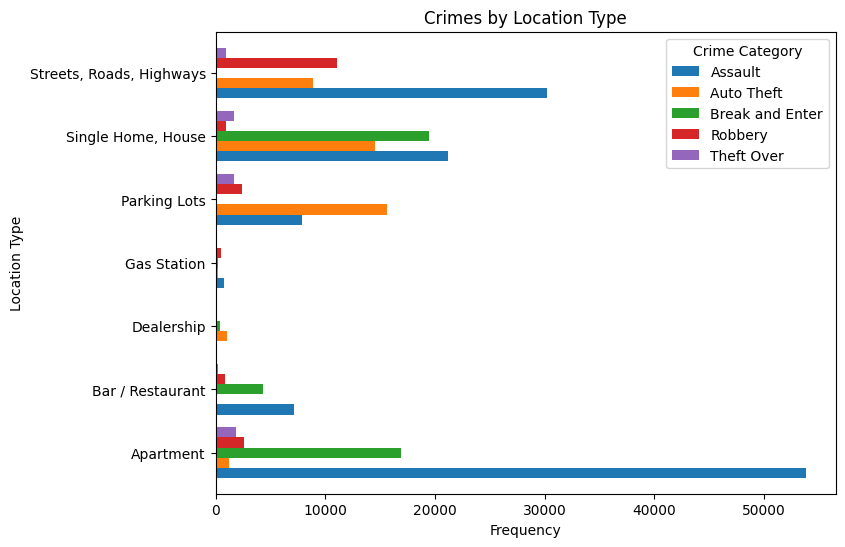

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

selected_cols = ['Streets, Roads, Highways', 'Single Home, House', 'Parking Lots', 'Dealership', 'Gas Station', 'Bar / Restaurant', 'Apartment']

ax = pd.crosstab(df[df.LOCATION_TYPE.isin(selected_cols)]['LOCATION_TYPE'], df['MCI_CATEGORY']).plot(kind='barh', width= 0.8, ax=ax)
ax.set_title('Crimes by Location Type')
ax.set_ylabel('Location Type')
ax.set_xlabel('Frequency')
ax.set_label("Crime Category")
# Get the legend object
legend = ax.legend()

# Set the title for the legend
legend.set_title('Crime Category')



We see that Auto Theft are prevelant in Parking lots, Single home (House), and Streets (Roads, Highway). There are also some Autotheft in Dealerships.